In [16]:
from keras.models import load_model
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

CRYPTOS = ["BTC-USD", "ETH-USD", "XRP-USD", "SOL-USD", "DOGE-USD"]
errors = {}
models = {coin: load_model(f"models/{coin}.keras") for coin in CRYPTOS}

for crypto in CRYPTOS:
    lb = 48
    data = yf.download(crypto, period="3d", interval="1h")['Close'].dropna()

    if len(data) < lb:
        print(f"Not enough data for {crypto}")
        continue

    scaler = MinMaxScaler(feature_range=(0, 1))
    prices = np.array(data).reshape(-1, 1)
    scaler.fit(prices)

    recent_data = prices[-lb:]
    scaled_input = scaler.transform(recent_data).reshape(1, lb, 1)

    pred_scaled = models[crypto].predict(scaled_input, verbose=0)
    pred = float(scaler.inverse_transform(pred_scaled)[0, 0])
    actual = data.iloc[-1].item()

    error_percent = ((pred - actual) / actual) * 100
    errors[crypto] = error_percent

print("✅ Error calculation complete.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Error calculation complete.


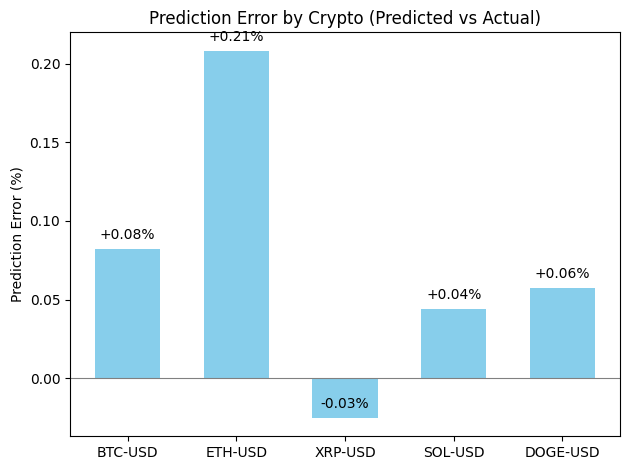

In [24]:
import matplotlib.pyplot as plt
import numpy as np

cryptos = list(errors.keys())
percent_errors = [errors[c] for c in cryptos]

x = np.arange(len(cryptos))
width = 0.6

fig, ax = plt.subplots()
bars = ax.bar(x, percent_errors, width, color='skyblue')

ax.set_ylabel('Prediction Error (%)')
ax.set_title('Prediction Error by Crypto (Predicted vs Actual)')
ax.set_xticks(x)
ax.set_xticklabels(cryptos)
ax.axhline(0, color='gray', linewidth=0.8)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:+.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


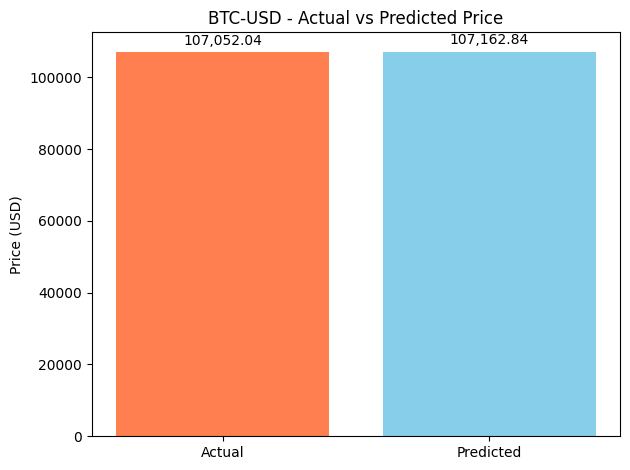

[*********************100%***********************]  1 of 1 completed


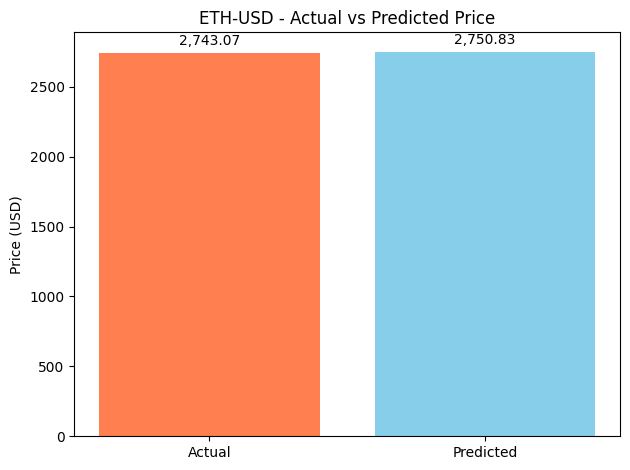

[*********************100%***********************]  1 of 1 completed


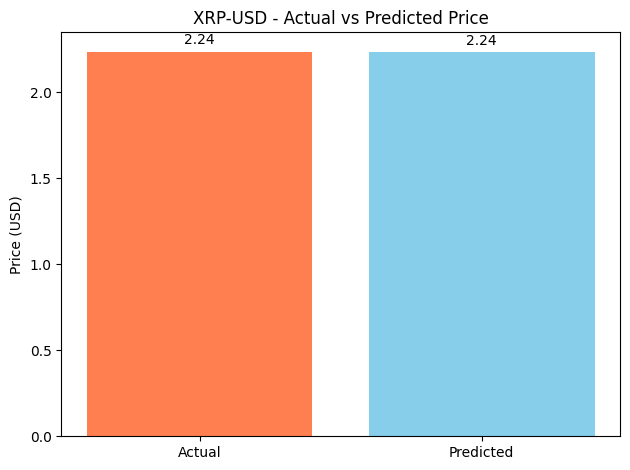

[*********************100%***********************]  1 of 1 completed


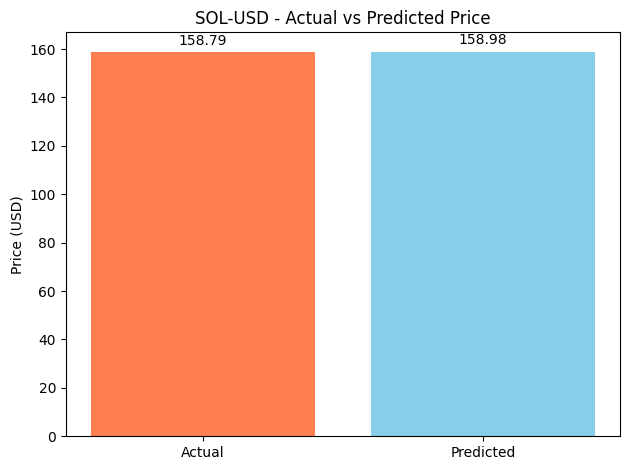

[*********************100%***********************]  1 of 1 completed


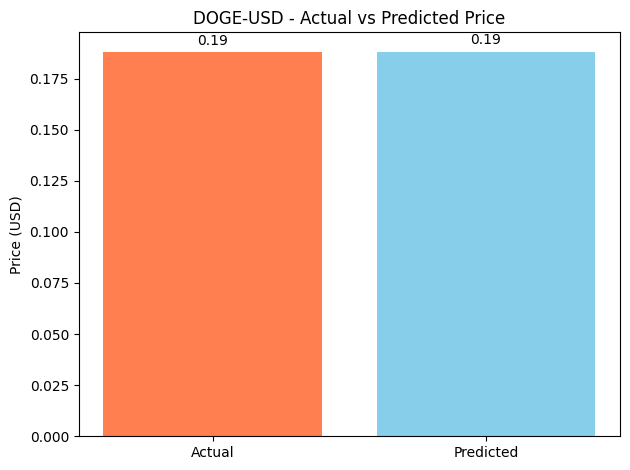

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

for crypto in CRYPTOS:
    lb = 48
    data = yf.download(crypto, period="3d", interval="1h")['Close'].dropna()

    if len(data) < lb:
        print(f"Skipping {crypto}, not enough data.")
        continue

    scaler = MinMaxScaler(feature_range=(0, 1))
    prices = np.array(data).reshape(-1, 1)
    scaler.fit(prices)

    recent_data = prices[-lb:]
    scaled_input = scaler.transform(recent_data).reshape(1, lb, 1)

    pred_scaled = models[crypto].predict(scaled_input, verbose=0)
    pred = float(scaler.inverse_transform(pred_scaled)[0, 0])
    actual = data.iloc[-1].item()

    # Plot
    fig, ax = plt.subplots()
    bars = ax.bar(['Actual', 'Predicted'], [actual, pred], color=['coral', 'skyblue'])

    ax.set_title(f'{crypto} - Actual vs Predicted Price')
    ax.set_ylabel('Price (USD)')

    # Annotate values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:,.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


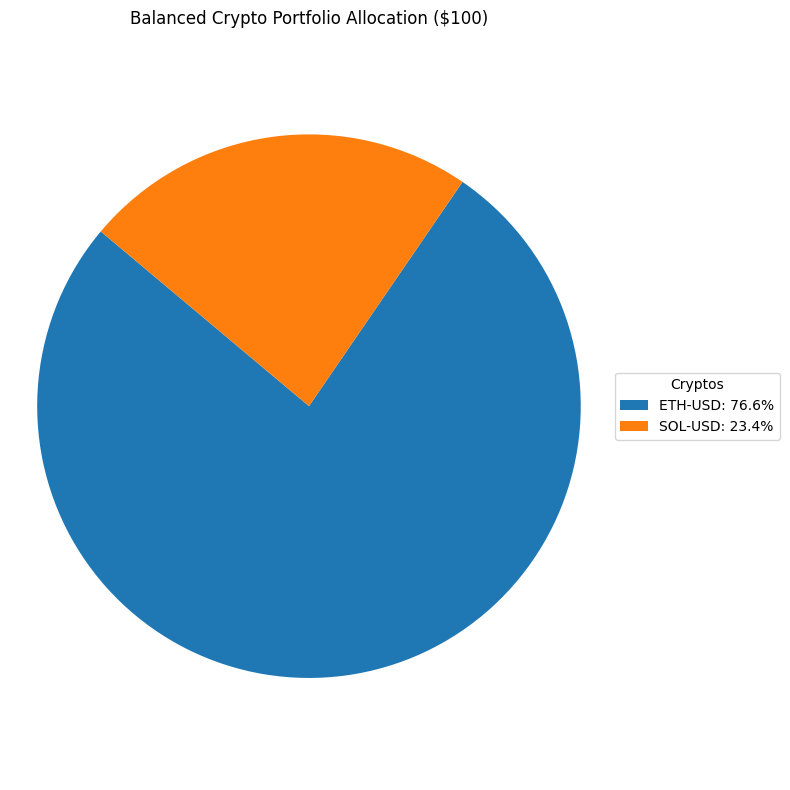

In [30]:
from keras.models import load_model
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import math

CRYPTOS = ["BTC-USD", "ETH-USD", "XRP-USD", "SOL-USD", "DOGE-USD"]
models = {coin: load_model(f"models/{coin}.keras") for coin in CRYPTOS}
allocations = {}

for crypto in CRYPTOS:
    data = yf.download(crypto, period="7d", interval="1h")['Close'].dropna()

    if len(data) < 48:
        print(f"Skipping {crypto}: Only {len(data)} data points")
        continue

    recent_48 = data[-48:]
    prices = np.array(recent_48).reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(prices)

    scaled_input = scaler.transform(prices).reshape(1, 48, 1)
    pred_scaled = models[crypto].predict(scaled_input, verbose=0)
    pred_price = float(scaler.inverse_transform(pred_scaled)[0, 0])

    start_price = recent_48.iloc[0].item()
    raw_growth = pred_price - start_price

    # Adjust using log-scaling to reduce penalty for high-priced coins
    safety_adjusted_growth = raw_growth / math.log(start_price + 10)

    if safety_adjusted_growth > 0:
        allocations[crypto] = safety_adjusted_growth

# Normalize to $100
total_score = sum(allocations.values())
if total_score == 0:
    print("No strong positive trends detected.")
else:
    weights = {k: (v / total_score) * 100 for k, v in allocations.items()}

    # Plot pie chart with legend
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, _ = ax.pie(weights.values(), startangle=140)
    ax.axis('equal')
    plt.title('Balanced Crypto Portfolio Allocation ($100)')

    labels = [f"{crypto}: {weights[crypto]:.1f}%" for crypto in weights]
    ax.legend(wedges, labels, title="Cryptos", loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()
